# Load and export velocity data

Gareth Funning, University of California, Riverside

An attempt to use MintPy functions to read in and export InSAR velocities.

# 1. Dependencies and functions

The dependencies are the same as those that MintPy needs $-$ so make sure they are installed!

In [46]:
# let's start with some dependencies 
# (needless to say if they are not installed, jupyter will be sad)
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime
import dateutil
from osgeo import gdal, osr
from mintpy.utils import readfile, utils as ut

In [47]:
# here is little function to find the nearest neighbor to a value in an array
# (minimal alteration from stack overflow)
def closest(lst, K):  
     lst = np.asarray(lst)
     idx = (np.abs(lst - K)).argmin()
     return idx

## 2. Load in and crop the data

The first step is to read in the data. Here we are using data from MintPy, although this ought to work for other datasets too. Each MintPy file contains a mixture of data layers ('subdatasets') and metadata information ('attributes') $-$ and we want both, ideally. 

This is a bit fiddly... we need to first read the attributes for each track in turn, to figure out the file dimensions and coordinates. Then we want load in multiple data layers from multiple files, and crop them to the same dimensions. Reading the attributes is easiest using one of the MintPy utilities, and we'll use Gdal for the actual data loading. The data files are HDF5 format, which is versatile, but potentially very complicated! 

The file 'timeseries.h5' for each track contains multiple subdatasets. By default the 'readfile.read' function reads in the 'timeseries' subdataset, which is a 3D array, with each layer representing cumulative displacement at each successive epoch.

It also contains a 'date' subdataset, which we load in a bit of a roundabout way (not sure if there is a better way?)


In [48]:
# for MintPy h5 files
# some file locations, names and details
datadir='./'

# define your crop area (set to zeros to use file bounds)
crop_minx=0
crop_maxx=0
crop_maxy=0
crop_miny=0

# MintPy filenames
velfile='velocity.h5'

# ------
# we begin with the descending data

# read in data and metadata for the descending data
print('reading data from input file '+datadir+velfile)
data, atr = readfile.read(datadir+velfile, datasetName='velocity')

# extract lat/lon information from the attributes
lat0 = float(atr['Y_FIRST']);  lat_step = float(atr['Y_STEP']);  lat_num = int(atr['LENGTH'])
lon0 = float(atr['X_FIRST']);  lon_step = float(atr['X_STEP']);  lon_num = int(atr['WIDTH'])
lat1 = lat0 + lat_step * lat_num
lon1 = lon0 + lon_step * lon_num
lats, lons = np.mgrid[lat0:lat1:lat_num*1j,
                      lon0:lon1:lon_num*1j]

# find the crop extents
if crop_minx:
    mincol=closest(lons[0], crop_minx)
else:
    mincol=0
    crop_minx=lon0

if crop_maxx:
    maxcol = closest(lons[0], crop_maxx)
else:
    maxcol=lon_num
    crop_maxx=lon1
    
if crop_maxy:
    maxrow=closest(lats[:,0], crop_miny)
else:
    maxrow=lat_num
    crop_maxy=lat0

if crop_miny:
    minrow = closest(lats[:,0], crop_maxy)
else: 
    minrow=0
    crop_miny=lat1
    
# optional bodge
#maxcol+=1
#maxrow+=1

# and crop the array to them
print('cropping to specified dimensions')
cropdata=data[minrow:maxrow,mincol:maxcol]
nrows = cropdata[:,0].size
ncols = cropdata[0,:].size

# make a new coordinate system
xx=np.linspace(crop_minx,crop_maxx,ncols)
yy=np.linspace(crop_maxy,crop_miny,nrows)
X, Y = np.meshgrid(xx,yy)


reading data from input file ./velocity.h5
cropping to specified dimensions


## 3. Plot the velocities and save them

Each layer of the 3D array containing the time series is a time slice of the cumulative displacement at the corresponding epoch. We want to look at these! And we can...

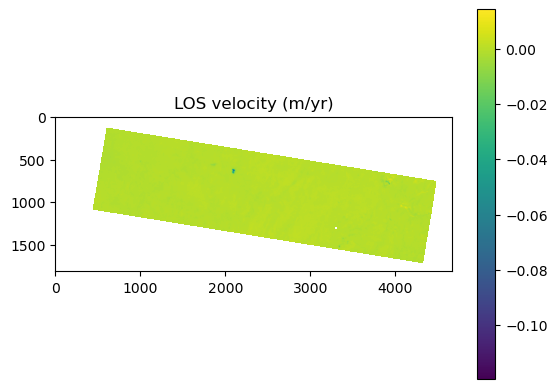

In [50]:
# plot the velocities you just loaded

plot_disp=cropdata
plot_disp[plot_disp==0]=np.nan

# let's plot the cumulative displacement data
fig1, ax1 = plt.subplots()                       # initiate a matplotlib plot
im1 = ax1.imshow(plot_disp)                         # plot displacements
ax1.set_title('LOS velocity (m/yr)')
jnk=fig1.colorbar(im1)    

And if you want to save this as a geotiff, you can!

If you are using hyp3 data, you will need to know your UTM zone information, however.

In [51]:
# output yer data as a geotiff

# what is your UTM zone?
utm_zone=12
utm_lett='S'

# calculate your EPSG code for geocoding
EPSG_code=32600+utm_zone  # if northern hemisphere
# EPSG_code=32700+utm_zone  # if southern hemisphere

# output filename
outdata='velocity'

# try to write out the cumulative displacement data in GeoTiff format
driver = gdal.GetDriverByName("GTiff")

outgrd = driver.Create(outdata+'.tif', ncols, nrows, 1, gdal.GDT_Float32)
outgrd.SetGeoTransform((crop_minx, lon_step, 0, crop_maxy, 0, lat_step))

outgrdSRS = osr.SpatialReference()
outgrdSRS.ImportFromEPSG(EPSG_code)
outgrd.SetProjection(outgrdSRS.ExportToWkt())

outband = outgrd.GetRasterBand(1)
outband.WriteArray(cropdata,0,0)
outband.FlushCache()                 # need this to actually write anything!
outband.SetNoDataValue(0)
outgrd = None
del outgrd, outband


NameError: name 'velocity' is not defined